## Introduction

Stan solution to [nested_model_example.ipynb](nested_model_example.ipynb).


In [1]:
# set up Python
import json
import inspect
import logging
import numpy as np
import pandas as pd
from IPython.display import Markdown
import plotnine
from plotnine import *

from nested_model_fns import (
    plot_forecast,
    plot_model_quality,
    plot_model_quality_by_prefix,
)
from stan_fns import (
    extract_sframe_result,
    generate_Stan_model_def,
    solve_forecast_by_Stan,
    plot_params,
    plot_past_and_future,
    plot_decomposition,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
with open("generating_params.json", "r") as file:
    generating_params = json.load(file)
modeling_lags = generating_params["generating_lags"]
beta_durable = generating_params["beta_durable"]
beta_transient = generating_params["beta_transient"]

In [3]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

## Solving again with the Bayesian "big hammer"


We now try a Bayesian model with the correct generative structure, using the [Stan](https://mc-stan.org/users/interfaces/cmdstan) software package.


In [4]:
# define a Stan model for both transient external regressors and future predictions
stan_model_with_forecast_src_i = generate_Stan_model_def(
        application_lags=modeling_lags,
        n_transient_external_regressors=len(beta_transient),
        n_durable_external_regressors=len(beta_durable),
    )

In [5]:
# show the model specification
display(Markdown(f"```stan\n{stan_model_with_forecast_src_i}\n```"))

```stan

data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;   // observed outcomes
  vector[N_y_observed + N_y_future] x_transient_1;  // observed transient external regressor
  vector[N_y_observed + N_y_future] x_durable_1;  // observed durable external regressor
}
parameters {
  real b_auto_0;                     // auto-regress intercept
  real effect_shift;                      // shift in effect moving from hidden to observed state
  vector[2] b_auto;                    // auto-regress coefficients
  vector[1] beta_transient;                                 // transient external regressor coefficients
  vector[1] beta_durable;                          // durable external regressor coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (transient) noise variance
  vector[N_y_observed + N_y_future] y_transient_effect;
}
transformed parameters {
        // y_observed and y_future in one notation (for export)
  vector[N_y_observed + N_y_future] y;
  vector[N_y_observed + N_y_future] t_intensity;
  y[1:N_y_observed] = y_observed;
  y[(N_y_observed + 1):(N_y_observed + N_y_future)] = y_future;
  t_intensity = beta_transient[1] * x_transient_1;
}
model {
  b_var_y_auto ~ chi_square(1);               // prior for y_auto (durable) noise variance
  b_var_y ~ chi_square(1);                    // prior for y (transient) noise variance
        // priors for parameter estimates
  b_auto_0 ~ normal(0, 10);
  effect_shift ~ normal(0, 10);
  for (i in 1:(N_y_observed + N_y_future)) {   // modeled transient effect
     if (t_intensity[i] > 0) {
        y_transient_effect[i] ~ normal(t_intensity[i], t_intensity[i] / 2);
     } else if (t_intensity[i] < 0) {
        y_transient_effect[i] ~ normal(t_intensity[i], -t_intensity[i] / 2);
     } else {
        y_transient_effect[i] ~ normal(0, 0.01);
     }
  }
  b_auto ~ normal(0, 10);
  beta_transient ~ normal(0, 10);
  beta_durable ~ normal(0, 10);
        // autoregressive system evolution
  y_auto[3:(N_y_observed + N_y_future)] ~ normal(
    b_auto_0 
     + b_auto[1] * y_auto[2:(N_y_observed + N_y_future - 1)]
     + b_auto[2] * y_auto[1:(N_y_observed + N_y_future - 2)] 
     + beta_durable[1] * x_durable_1[3:(N_y_observed + N_y_future)],
    b_var_y_auto);
        // criticize observations
  for (i in 1:N_y_observed) {
      if (y_observed[i] > 0) {
        target += normal_lpdf(
            y_observed[i] |
            effect_shift + y_transient_effect[i] + y_auto[i], 
            b_var_y); 
      } else {
        target += normal_lcdf(  // Tobit style scoring, matching above loss
            0 |
            effect_shift + y_transient_effect[i] + y_auto[i], 
            b_var_y); 
      }
  }
        // future
  y_future ~ normal(
    effect_shift + y_transient_effect[(N_y_observed + 1):(N_y_observed + N_y_future)] + y_auto[(N_y_observed + 1):(N_y_observed + N_y_future)], 
    b_var_y);
}

```

`y` and `y_auto` are supposed to be non-negative (a constraint we have chosen to *not* enforce, as it degraded results, probably by damaging sampling paths).

Please keep in mind a distributional statement such as <code>y ~ normal(f(y_auto, x), &sigma;)</code> is actually modeling the residual <code>(y - f(y_auto, x))</code> as being distributed <code>normal(0, &sigma;)</code>. So the above model-block statements are distributional assumptions about *residuals*, as the intended mean is an input to these statements. Thus we are specifying a normal distribution for residuals, not a normal distribution for expected values or predictions. I feel the normal approximation for `y`'s residual is not that bad. A similar statement can be made for `y_auto`'s residuals.

All in all: specifying systems to Stan is a compromise in respecting problem structure, and preserving the ability to effectively sample. The specification tends to requires some compromise and experimentation. In my opinion, it isn't quite the case that "Bayes' Law names only one legitimate inferential network and we can then use that one!" One is going to have to specify an approximate system. It becomes the user's responsibility to design for a (hopefully) high utility tradeoff between fidelity and realizability.

We obviously will not know all the priors. So we hope the problem is somewhat insensitive to them and just set them to not so bad distributions. It is possible to over-worry on priors, and somewhat freeing to just think of them as [regularizations](https://en.wikipedia.org/wiki/Regularization_(mathematics)) or biases for the values in question to be small. Think of the model statements as "criticisms" and not if they are prior (before seeing data) or posterior (after seeing data) opinions.

What Stan generates is: thousands of possible trajectories of parameters, and past and future hidden state.


In [6]:
# sample from Stan model solutions
forecast_soln_i = solve_forecast_by_Stan(
    model_src=stan_model_with_forecast_src_i,
    d_train=d_train,
    d_apply=d_test,
    durable_external_regressors=["x_durable_0"],
    transient_external_regressors=["x_transient_0"],
    cache_file_name='forecast_soln_i.csv.gz',
)

forecast_soln_i  # see https://mc-stan.org/docs/cmdstan-guide/stansummary.html

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,effect_shift,b_auto[0],...,t_intensity[990],t_intensity[991],t_intensity[992],t_intensity[993],t_intensity[994],t_intensity[995],t_intensity[996],t_intensity[997],t_intensity[998],t_intensity[999]
0,-4125.5300,0.956800,0.001643,10.0,1023.0,0.0,5089.590,0.350759,72.2580,0.489969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.87948
1,-4144.8800,0.985053,0.001643,10.0,1023.0,0.0,5149.930,0.362558,72.3908,0.386891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.17009
2,-4158.4400,0.919956,0.001643,10.0,1023.0,0.0,5173.390,0.390211,69.2991,0.413779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.84667
3,-4200.3600,0.999912,0.001643,10.0,1023.0,0.0,5225.240,0.348708,69.6763,0.457218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.61945
4,-4203.5200,0.839179,0.001643,10.0,1023.0,0.0,5224.860,0.408928,69.4419,0.362754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.97434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,136.7930,0.902537,0.000623,10.0,1023.0,0.0,898.745,3.267430,-21.3893,1.909910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.41160
3996,145.9750,0.940398,0.000623,10.0,1023.0,0.0,878.850,3.113390,-21.2162,1.918210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.55970
3997,145.2110,0.912683,0.000623,10.0,1023.0,0.0,823.101,3.115330,-21.2637,1.944120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.26570
3998,39.4818,0.713829,0.000623,10.0,1023.0,0.0,937.815,3.190980,-21.1117,1.914170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.07520


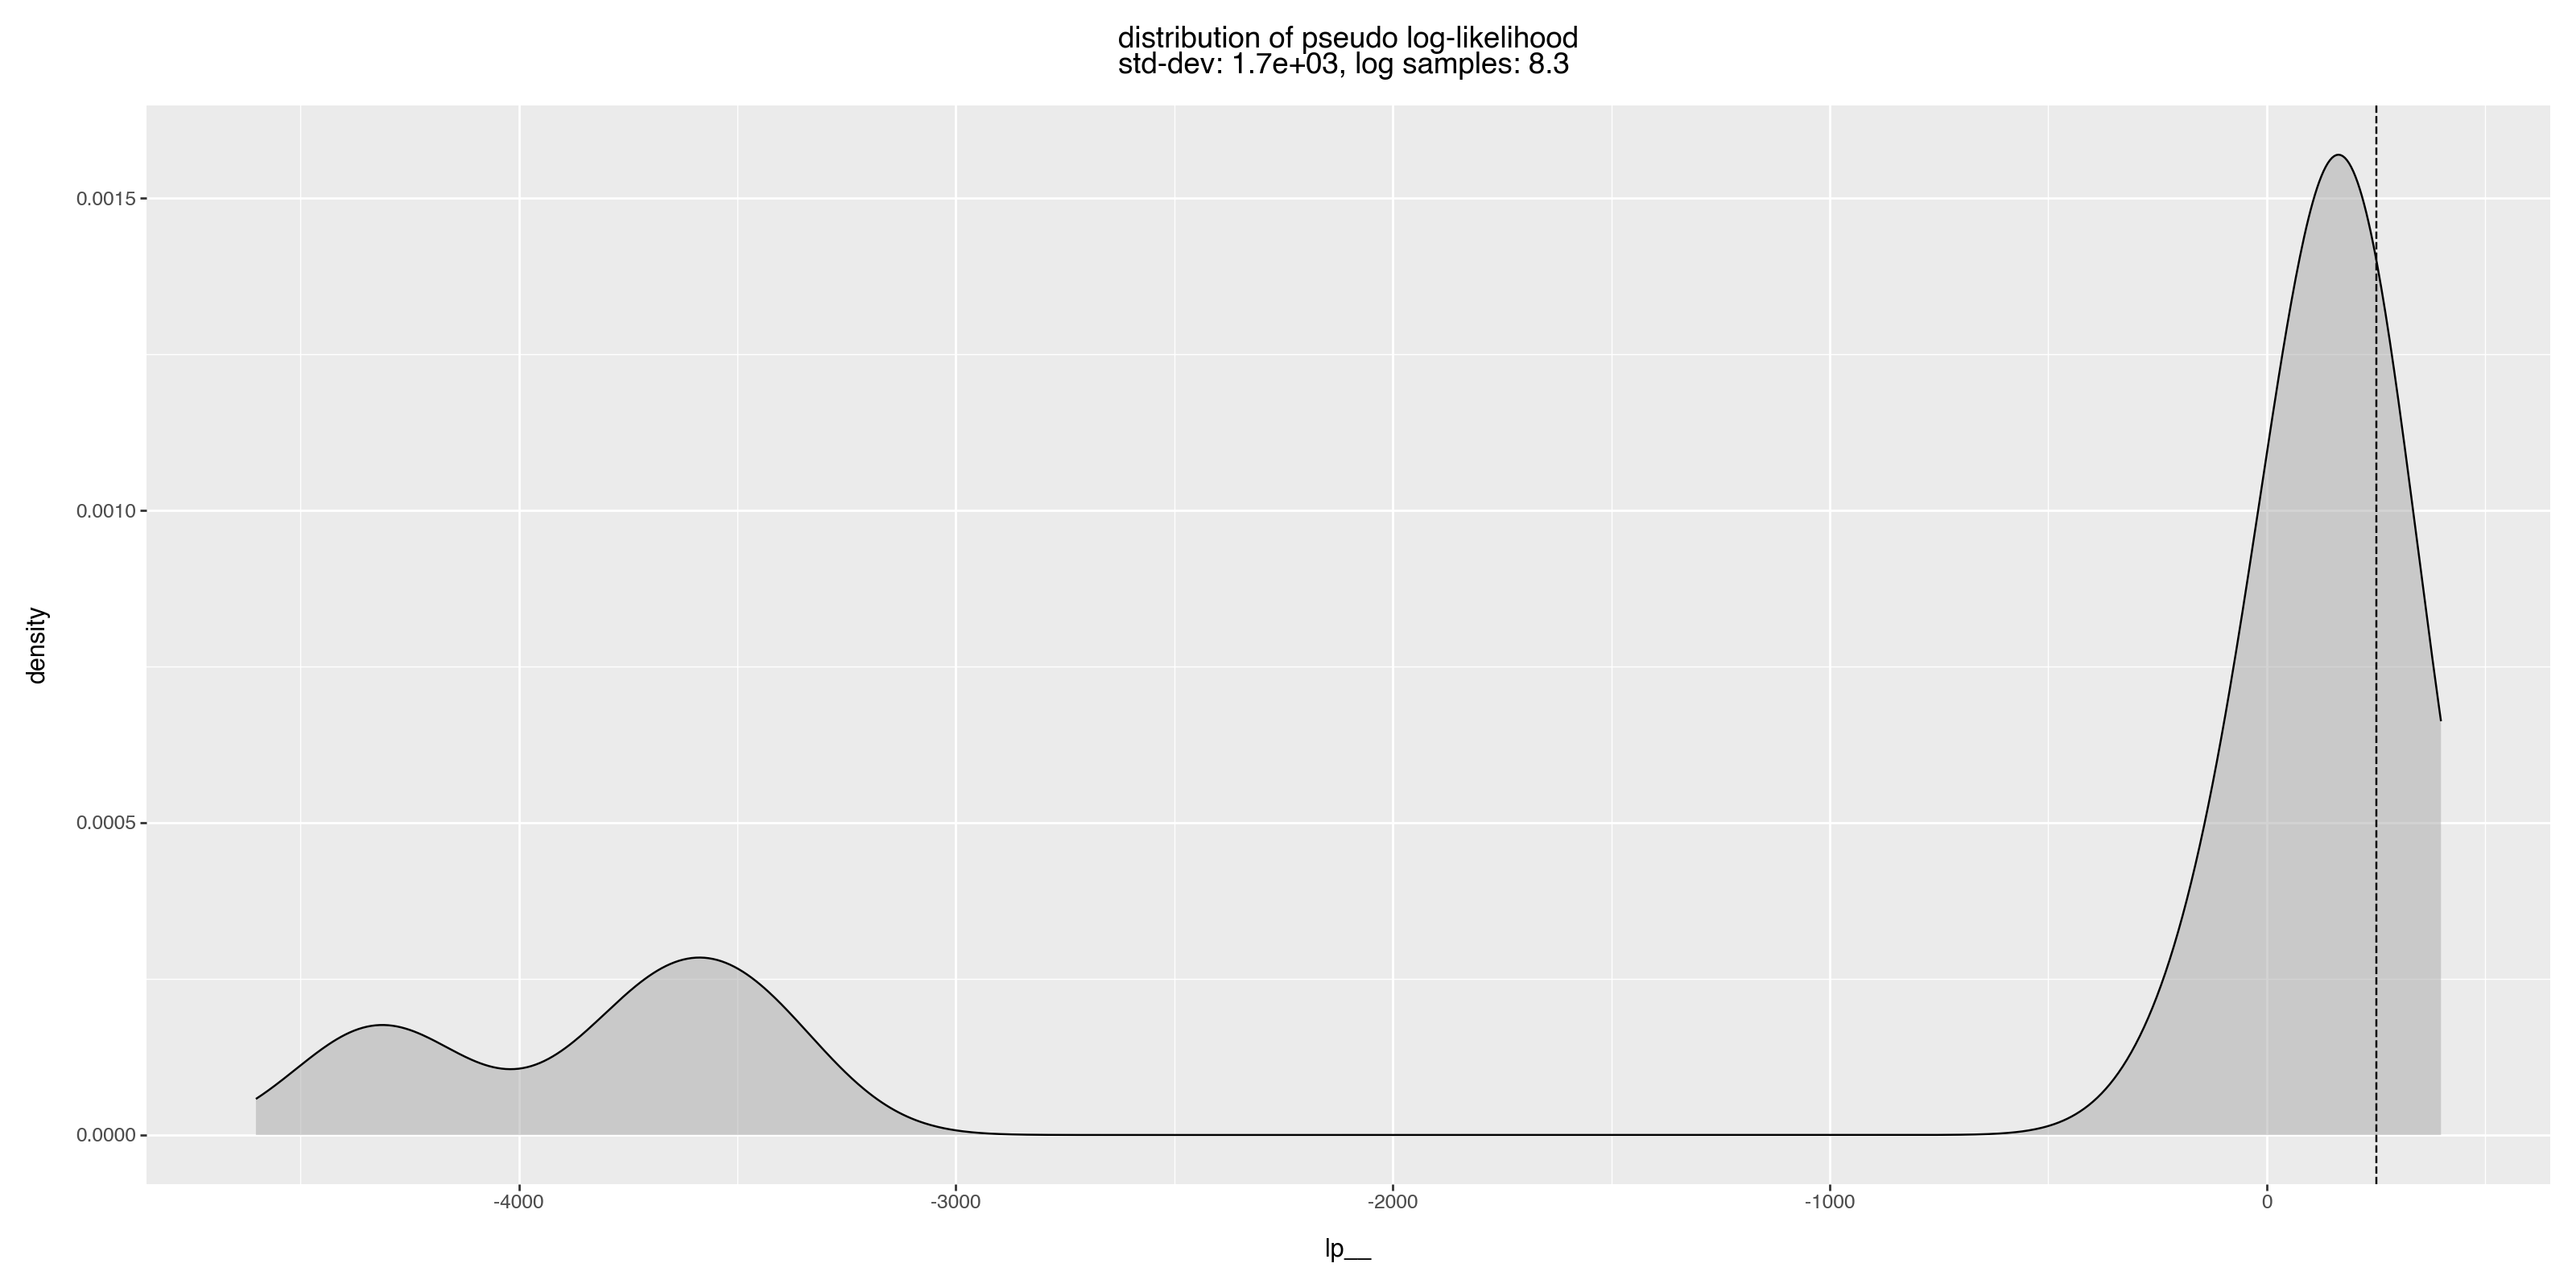

In [7]:
lp__q_90 = forecast_soln_i['lp__'].quantile(q=0.9)
lp__sd = forecast_soln_i['lp__'].std()
log_samples = np.log(forecast_soln_i.shape[0])
(
    ggplot(
        data=forecast_soln_i,
        mapping=aes(x='lp__')
    )
    + geom_density(fill="darkgrey", alpha=0.5)
    + geom_vline(xintercept=lp__q_90, linetype="dashed")
    + ggtitle(f"distribution of pseudo log-likelihood\nstd-dev: {lp__sd:0.2g}, log samples: {log_samples:0.2g}")
)

`lp__` is a shifted copy of the log-likelihood. We expect in most situations the distribution of `lp__` will be unimodal and to have a standard deviation not larger than `k log(n_samples)` for some small integer `k`. The first point is fairly technical and can be related to how fast volumes grow in large dimension (similar ideas include [the asymptotic equipartition theorem](https://en.wikipedia.org/wiki/Asymptotic_equipartition_property), [the law of the iterated logarithm](https://en.wikipedia.org/wiki/Law_of_the_iterated_logarithm)). The second part is simpler: with only `n_samples` we don't expect to often see events much rarer than `1/n_samples`, so if we trajectories with log-likelihood `lp__ + c` then we shouldn't see a lot of trajectories with log-likelihood `lp__ + c - k * log(n_samples)`.  So when we do see multimodality and/or wide dispersions of `lp__`, we do have a pathology. This is one of our motivations in filtering to more likely samples, in addition to these samples representing better fits.

Note: one can over-play this. Stan samples are designed so that <code>(sum<sub>i sample</sub> v<sub>i</sub>) / (sum<sub>i sample</sub> 1)</code> approximates <code>E[v]</code>, not <code>(sum<sub>i sample</sub> exp(lp__) v<sub>i</sub>) / (sum<sub>i sample</sub> exp(lp__))</code>. I.e. the samples are already *implicitly* weighted by how often the sampling system finds them, so plugging in the likelihood again is not fully justified.

In [8]:
# a trick I like: limit down to the more plausible samples/trajectories
forecast_soln_i = (
    forecast_soln_i.loc[
        forecast_soln_i['lp__'] >= lp__q_90,
        :
    ].reset_index(drop=True, inplace=False)
)

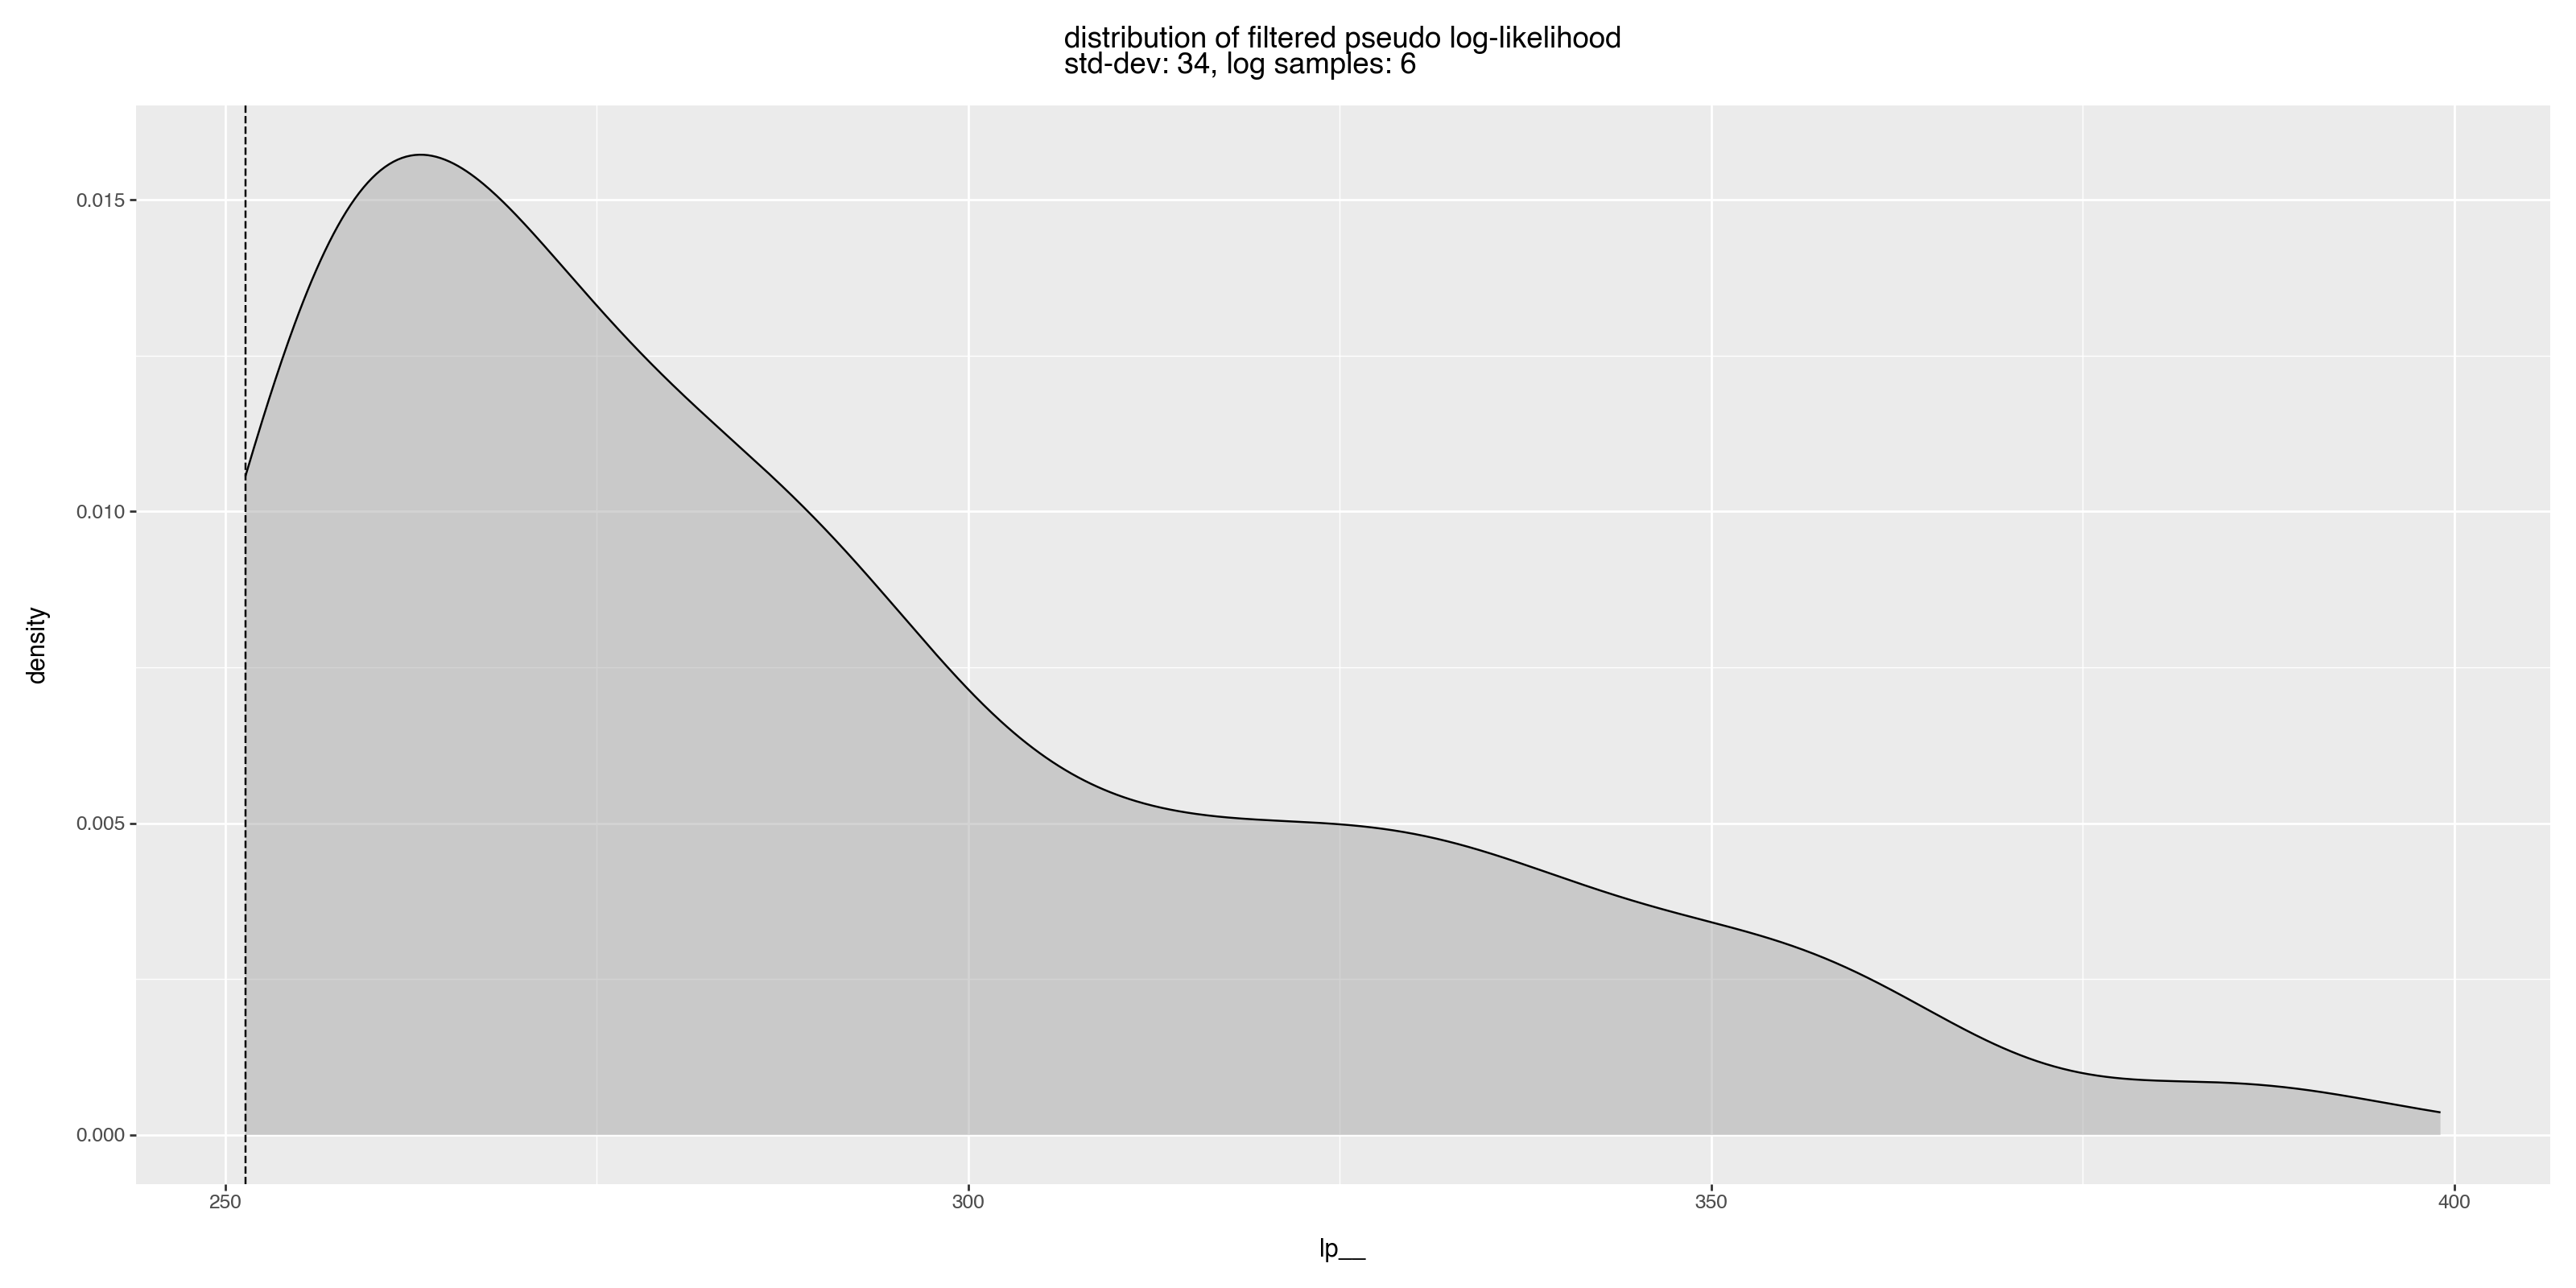

In [9]:

lp__sd = forecast_soln_i['lp__'].std()
log_samples = np.log(forecast_soln_i.shape[0])
(
    ggplot(
        data=forecast_soln_i,
        mapping=aes(x='lp__')
    )
    + geom_density(fill="darkgrey", alpha=0.5)
    + geom_vline(xintercept=lp__q_90, linetype="dashed")
    + ggtitle(f"distribution of filtered pseudo log-likelihood\nstd-dev: {lp__sd:0.2g}, log samples: {log_samples:0.2g}")
)

We can look at a summary of the parameter estimates.


In [10]:
# summarize parameter estimates
soln_params_i = forecast_soln_i.loc[
    :, [c for c in forecast_soln_i if c.startswith("b_")]
].median()

soln_params_i

b_auto_0        3.281450
b_auto[0]       1.930700
b_auto[1]      -0.963378
b_var_y_auto    1.823540
b_var_y         3.308880
dtype: float64

In [11]:
# show original generative parameters
generating_params

{'beta_auto_intercept': 2.1276366691753177,
 'effect_shift': -10.4,
 'beta_auto': [1.9727226068054446, -1],
 'beta_durable': [9.2],
 'beta_transient': [19.1],
 'generating_lags': [1, 2],
 'error_scale': 3.2,
 'n_step': 1000}

Notice we recover fair estimates `beta_durable` and `beta_transient` (they are not excessively shrunk to zero). These effect inferences can be used for planning and policy.

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 126 rows containing non-finite values.


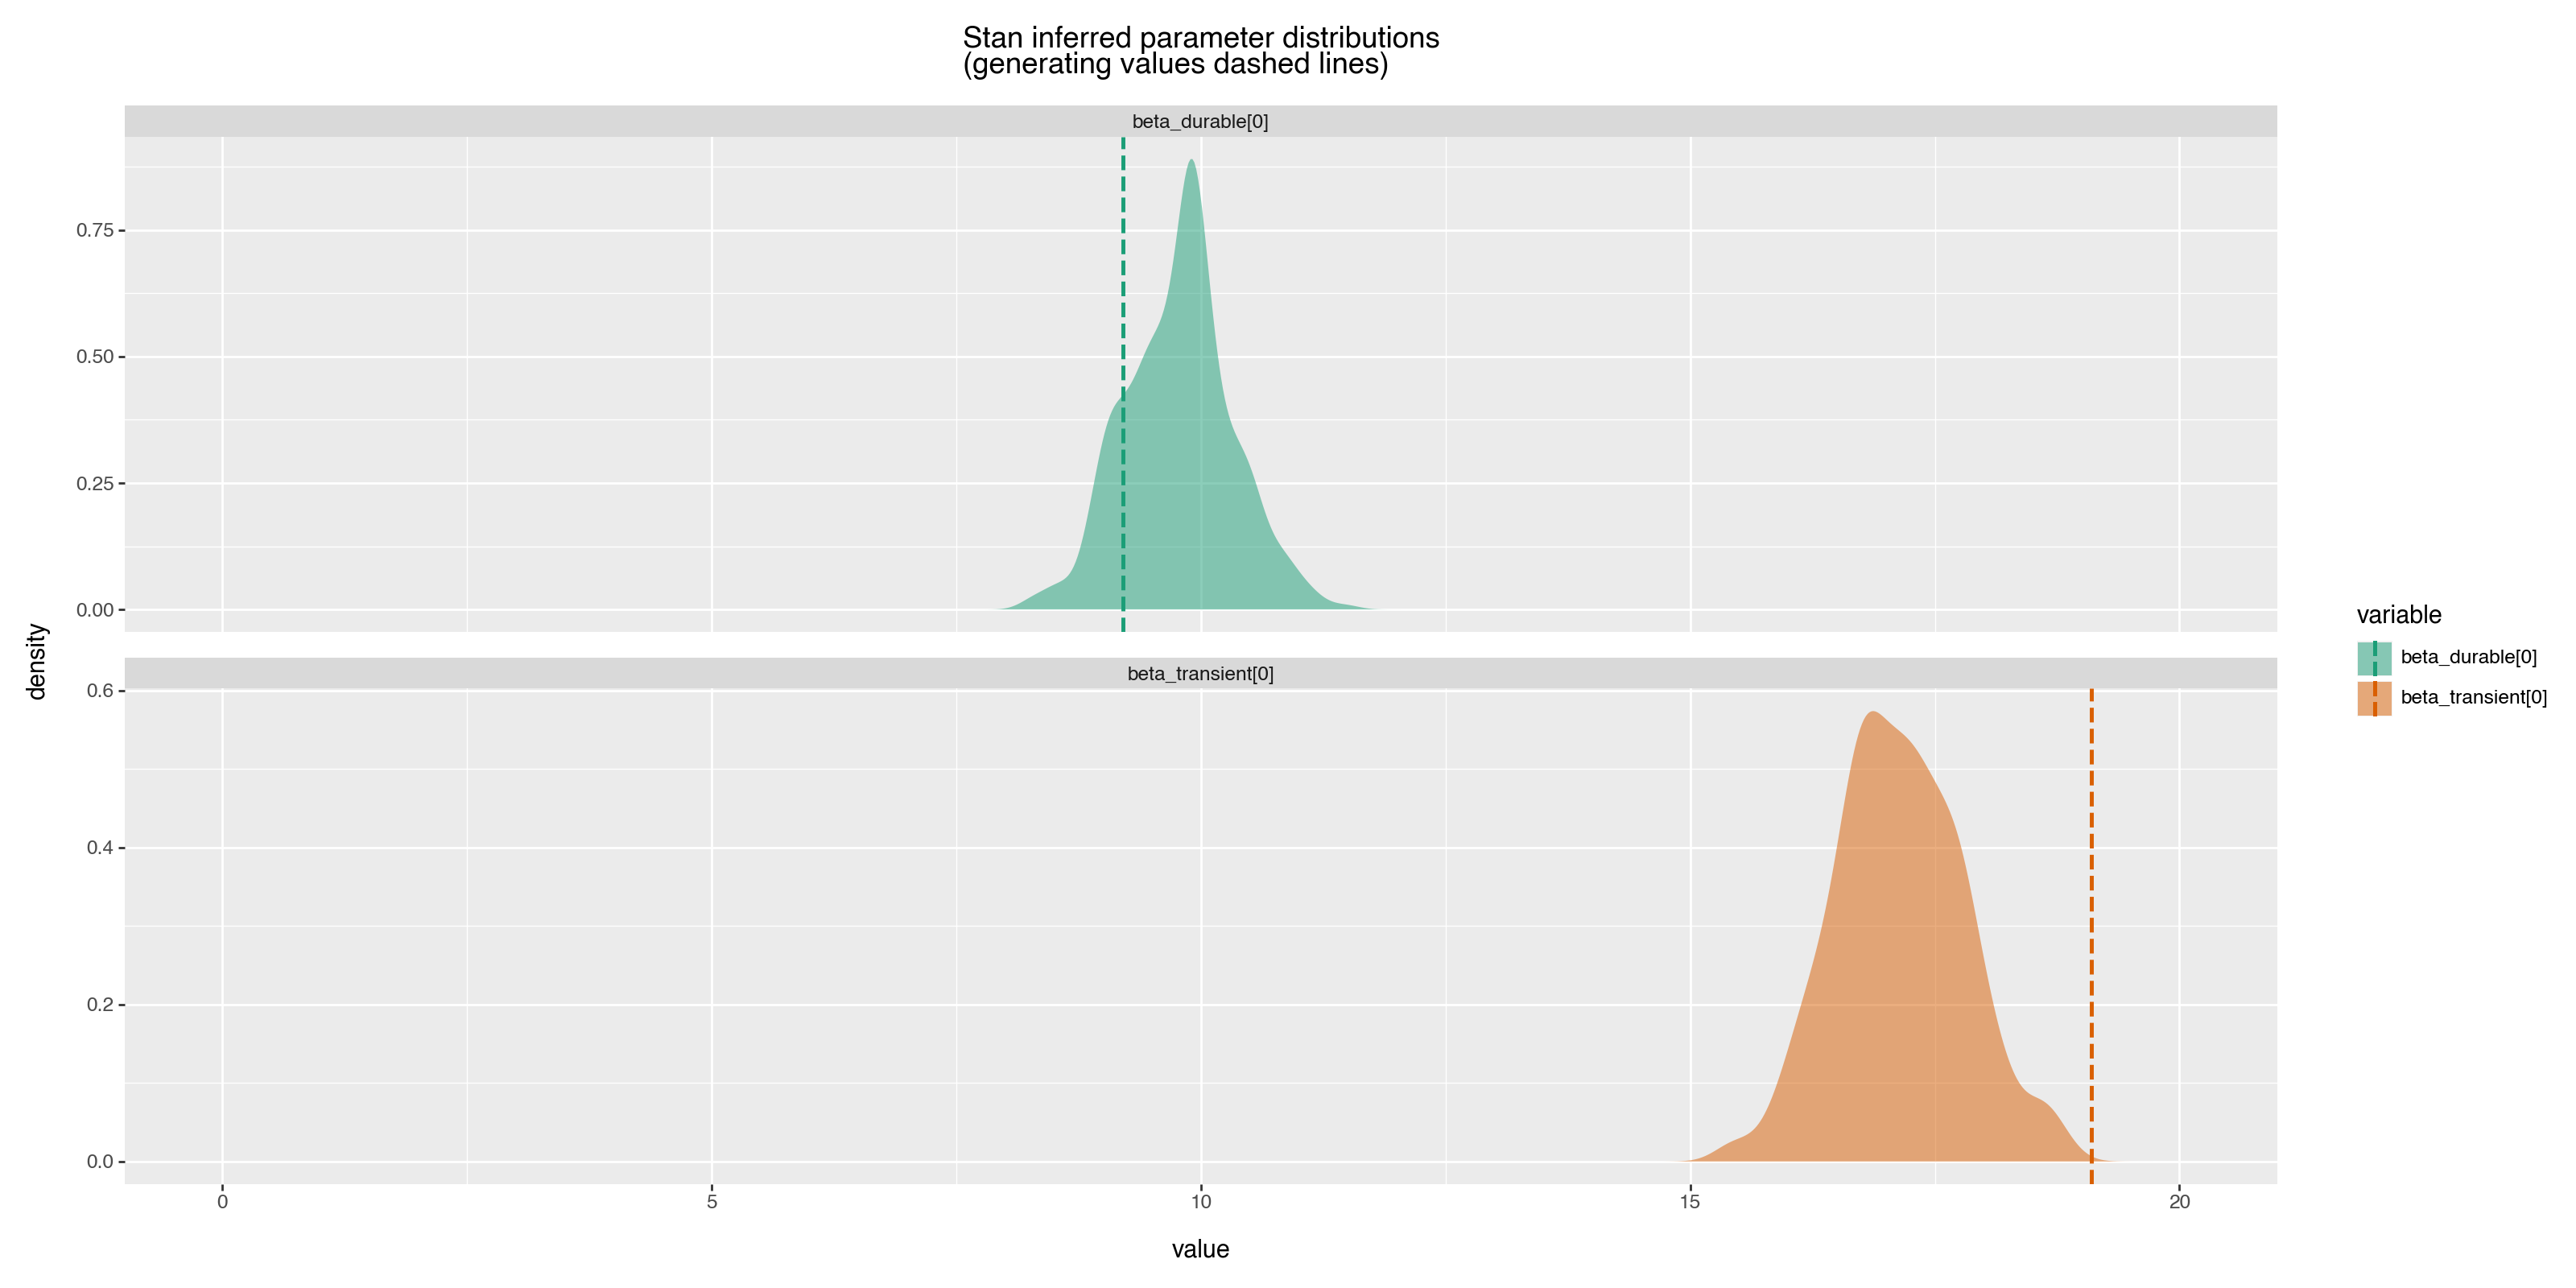

In [12]:
plot_params(
    forecast_soln_i=forecast_soln_i,
    generating_params=generating_params,
)

And we can plot both the forecasts, and *estimated* quantile bands around the estimated forecasts.


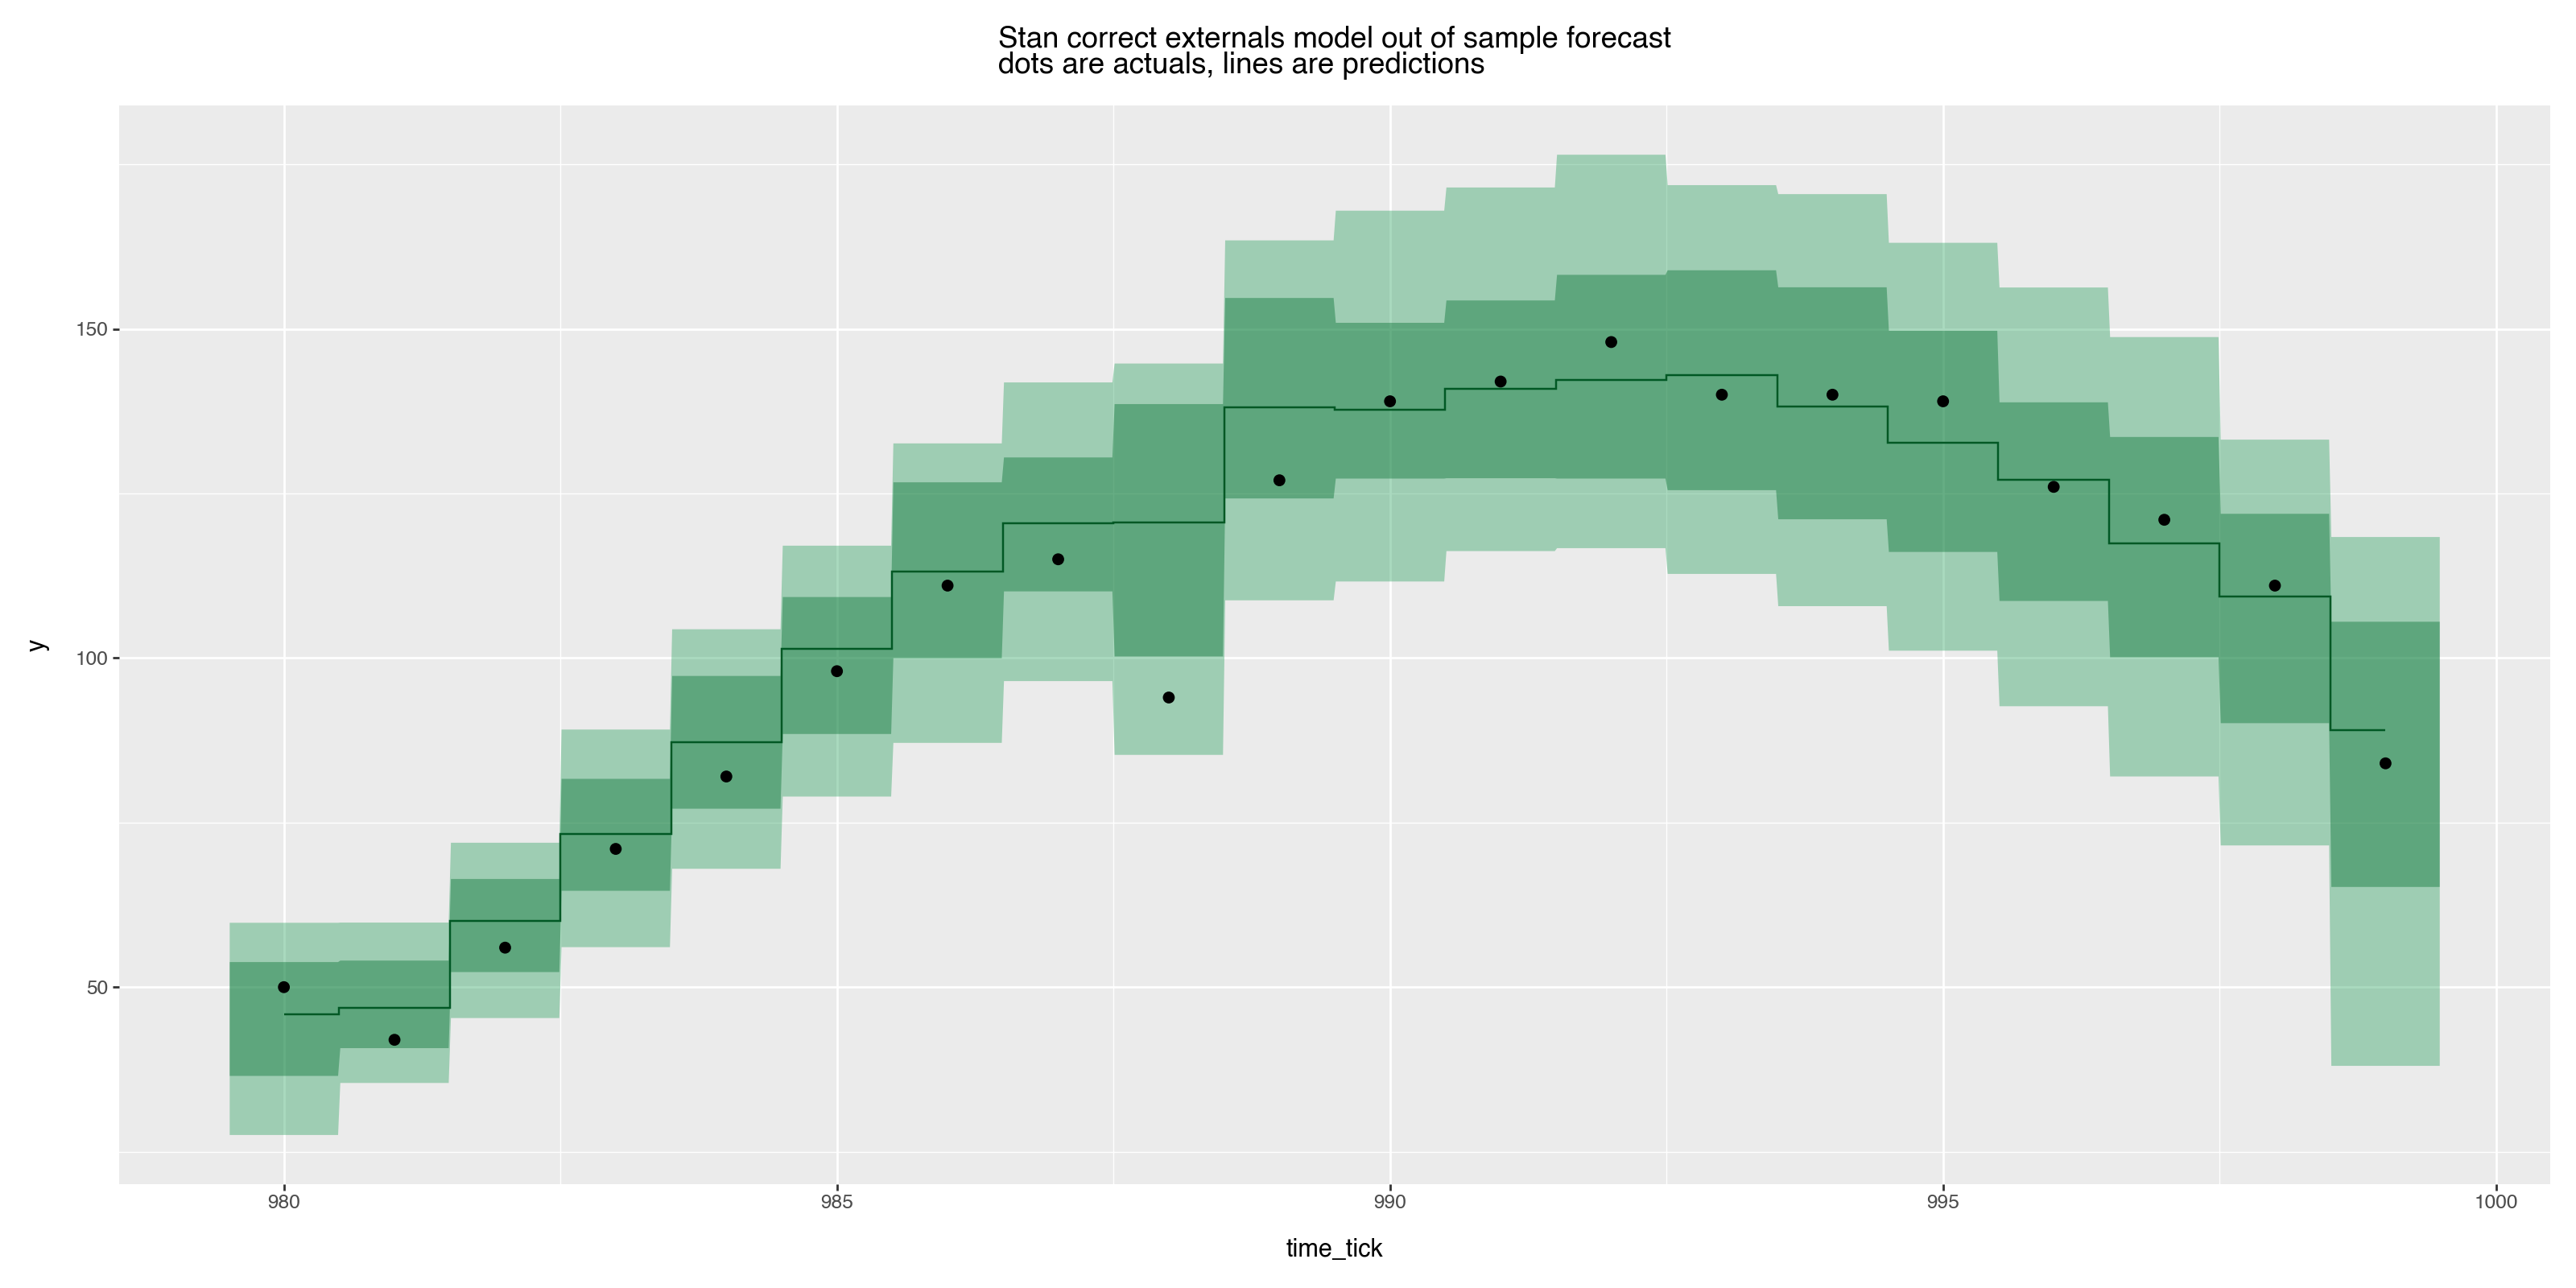

In [13]:
# plot inference over time
plt_i, s_frame_i = plot_forecast(
    forecast_soln_i,
    d_test,
    model_name="Stan correct externals model",
)
plt_i.show()

In [14]:
forecast_soln_i

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,effect_shift,b_auto[0],...,t_intensity[990],t_intensity[991],t_intensity[992],t_intensity[993],t_intensity[994],t_intensity[995],t_intensity[996],t_intensity[997],t_intensity[998],t_intensity[999]
0,253.513,0.636274,0.000721,10.0,1023.0,0.0,756.039,3.41580,-26.0872,1.93221,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.012715
1,286.312,0.779498,0.000721,10.0,1023.0,0.0,731.010,3.56884,-27.2300,1.93886,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.012794
2,252.096,0.878287,0.000721,10.0,1023.0,0.0,719.926,3.25884,-27.0480,1.94220,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.014070
3,266.980,0.795594,0.000721,10.0,1023.0,0.0,758.784,3.37782,-29.2563,1.93560,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.010644
4,270.710,0.935701,0.000721,10.0,1023.0,0.0,713.625,3.40166,-29.9443,1.92851,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.010531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,256.883,0.916756,0.000623,10.0,1023.0,0.0,796.838,3.01875,-22.8924,1.92867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.133400
396,275.692,0.925823,0.000623,10.0,1023.0,0.0,707.444,3.35615,-20.6911,1.93677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.078800
397,262.455,0.766507,0.000623,10.0,1023.0,0.0,732.418,3.24224,-20.2035,1.92956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.701300
398,257.367,0.944524,0.000623,10.0,1023.0,0.0,752.445,2.98669,-20.6630,1.93064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.641100


In [15]:
p1, p2 = plot_past_and_future(forecast_soln_i=forecast_soln_i, d_train=d_train, d_test=d_test)

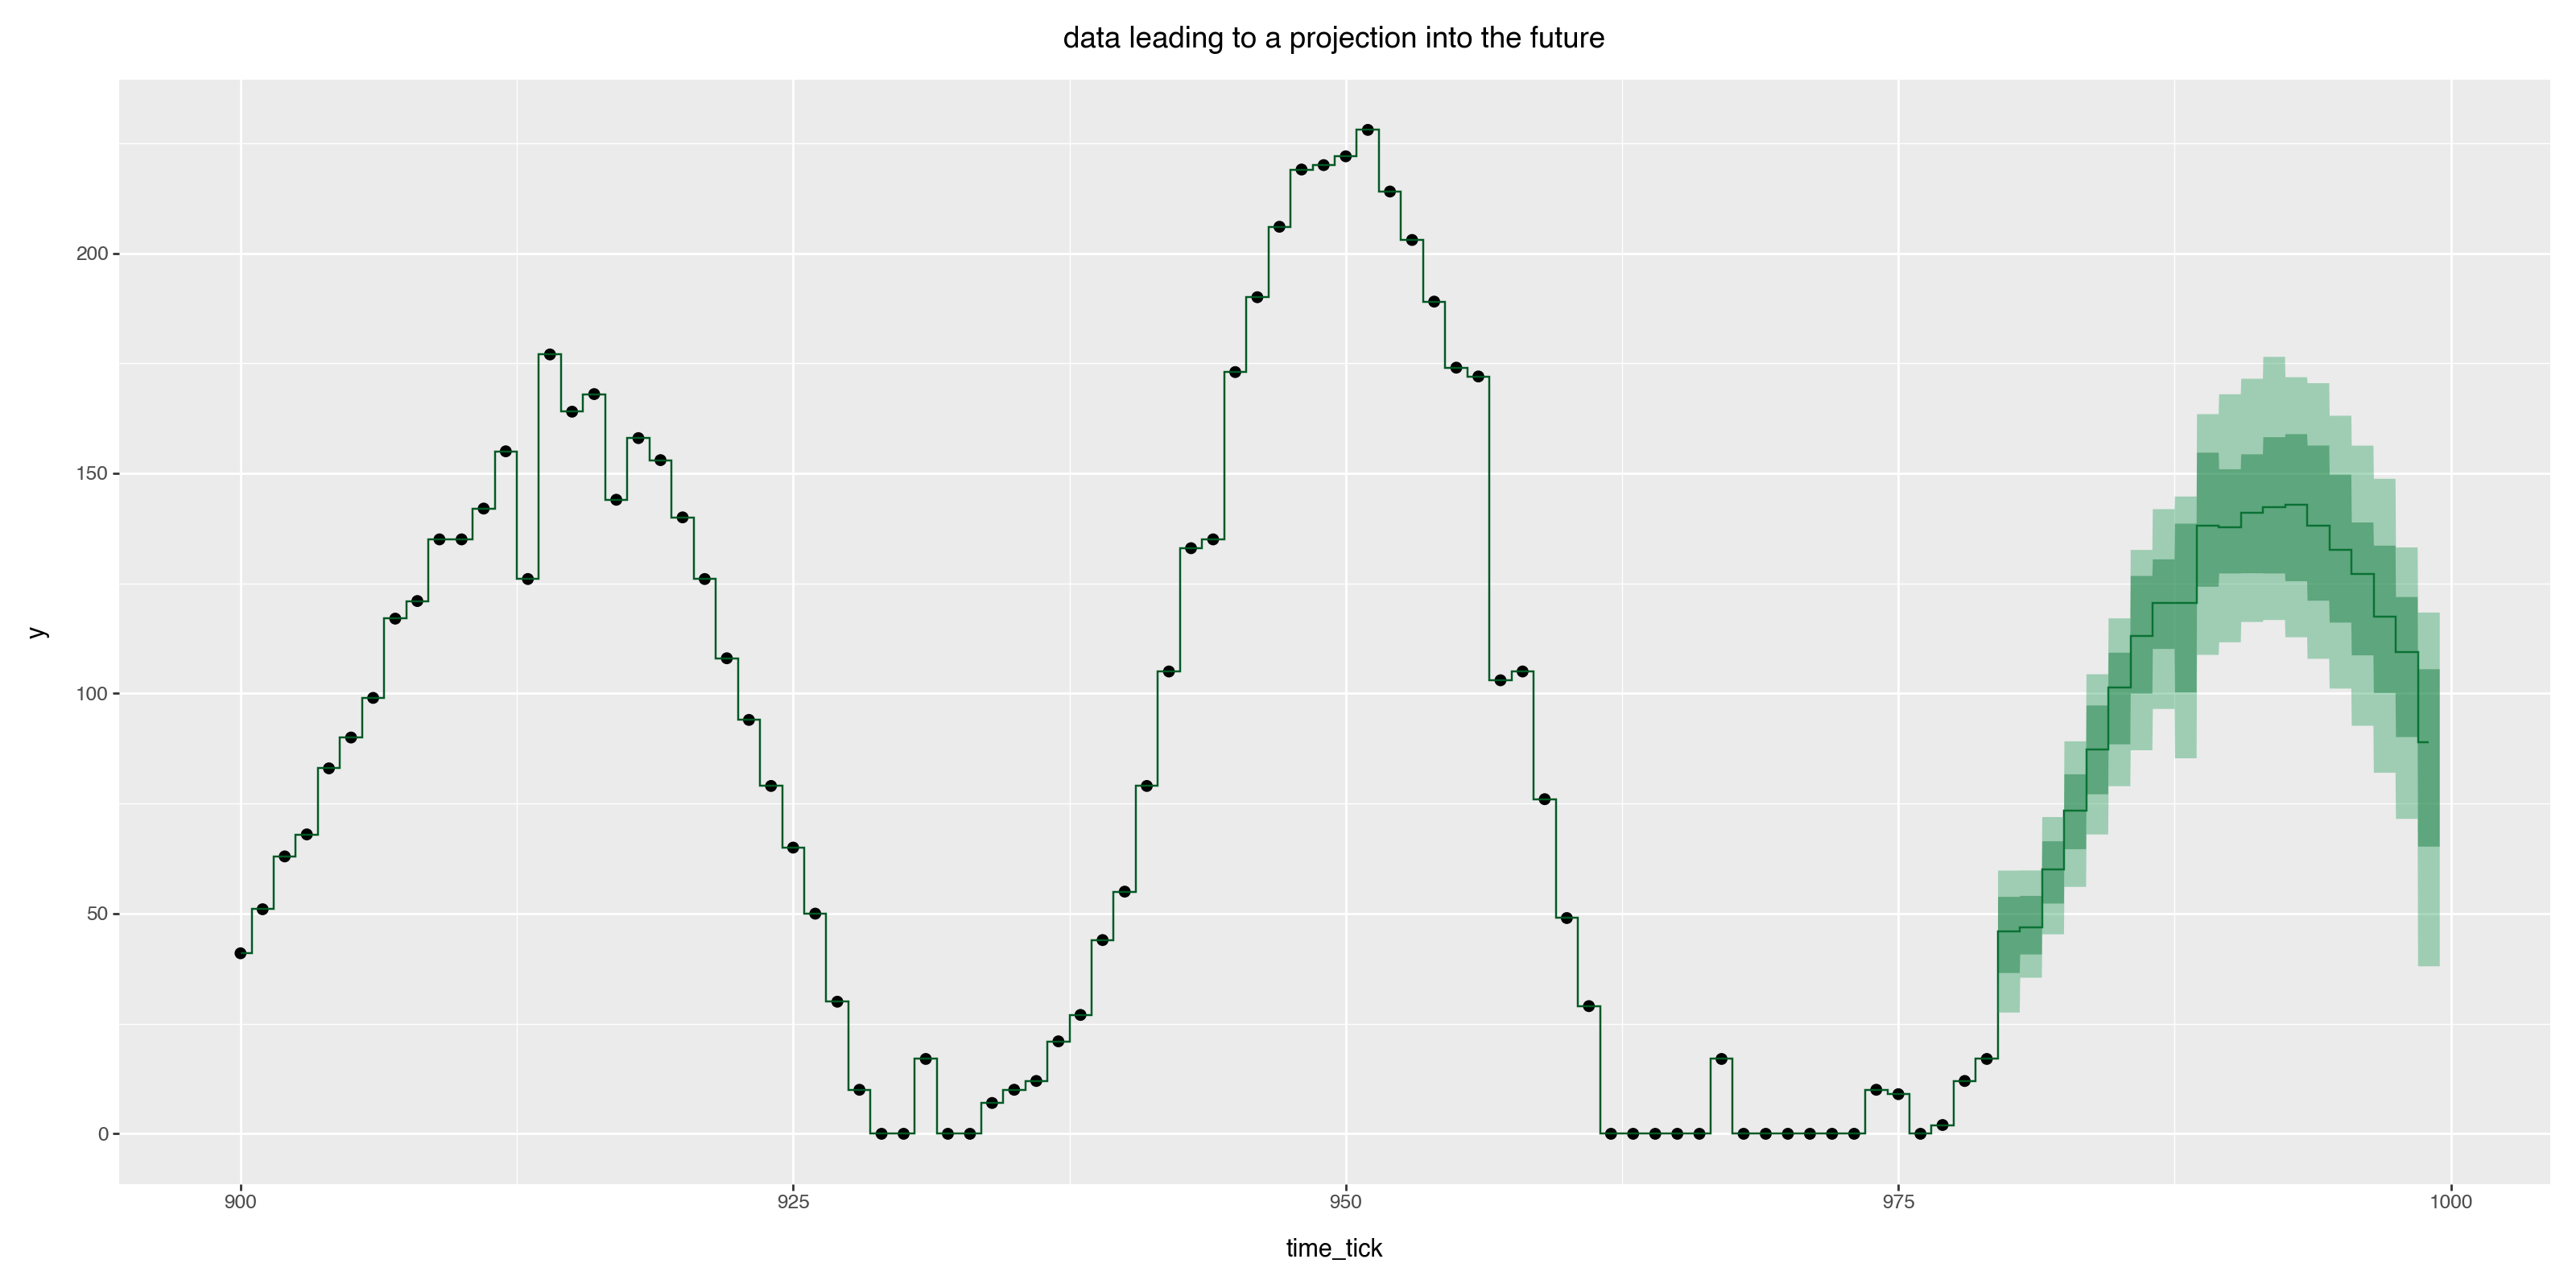

In [16]:
display(p1)

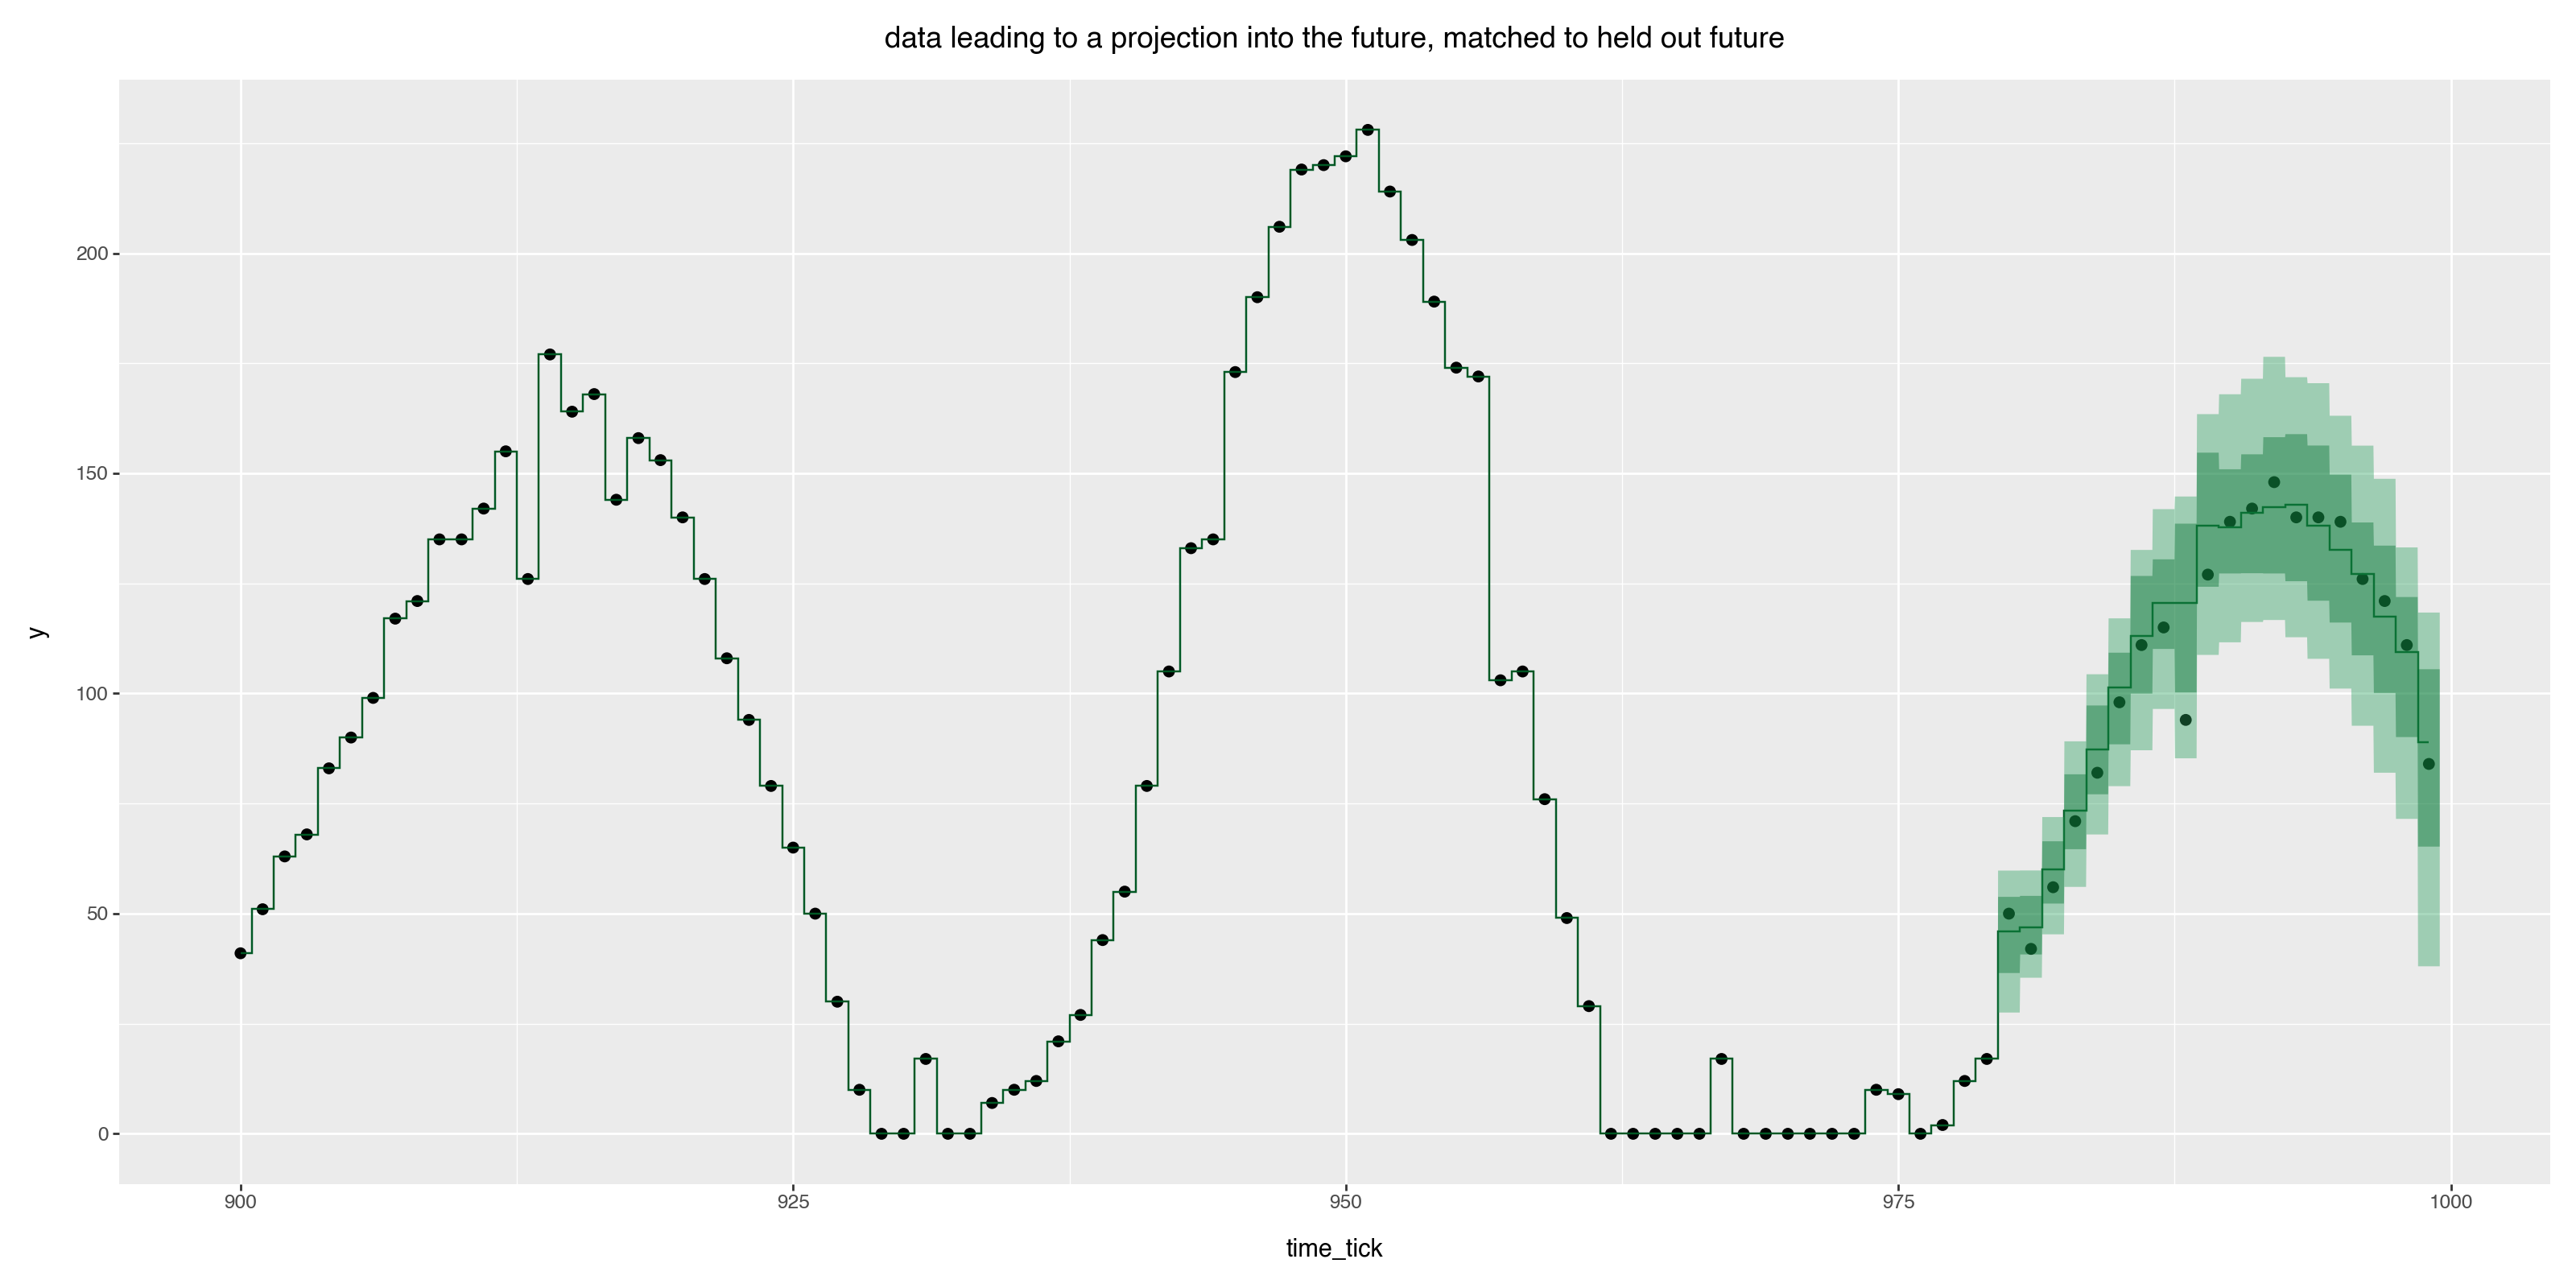

In [17]:
display(p2)

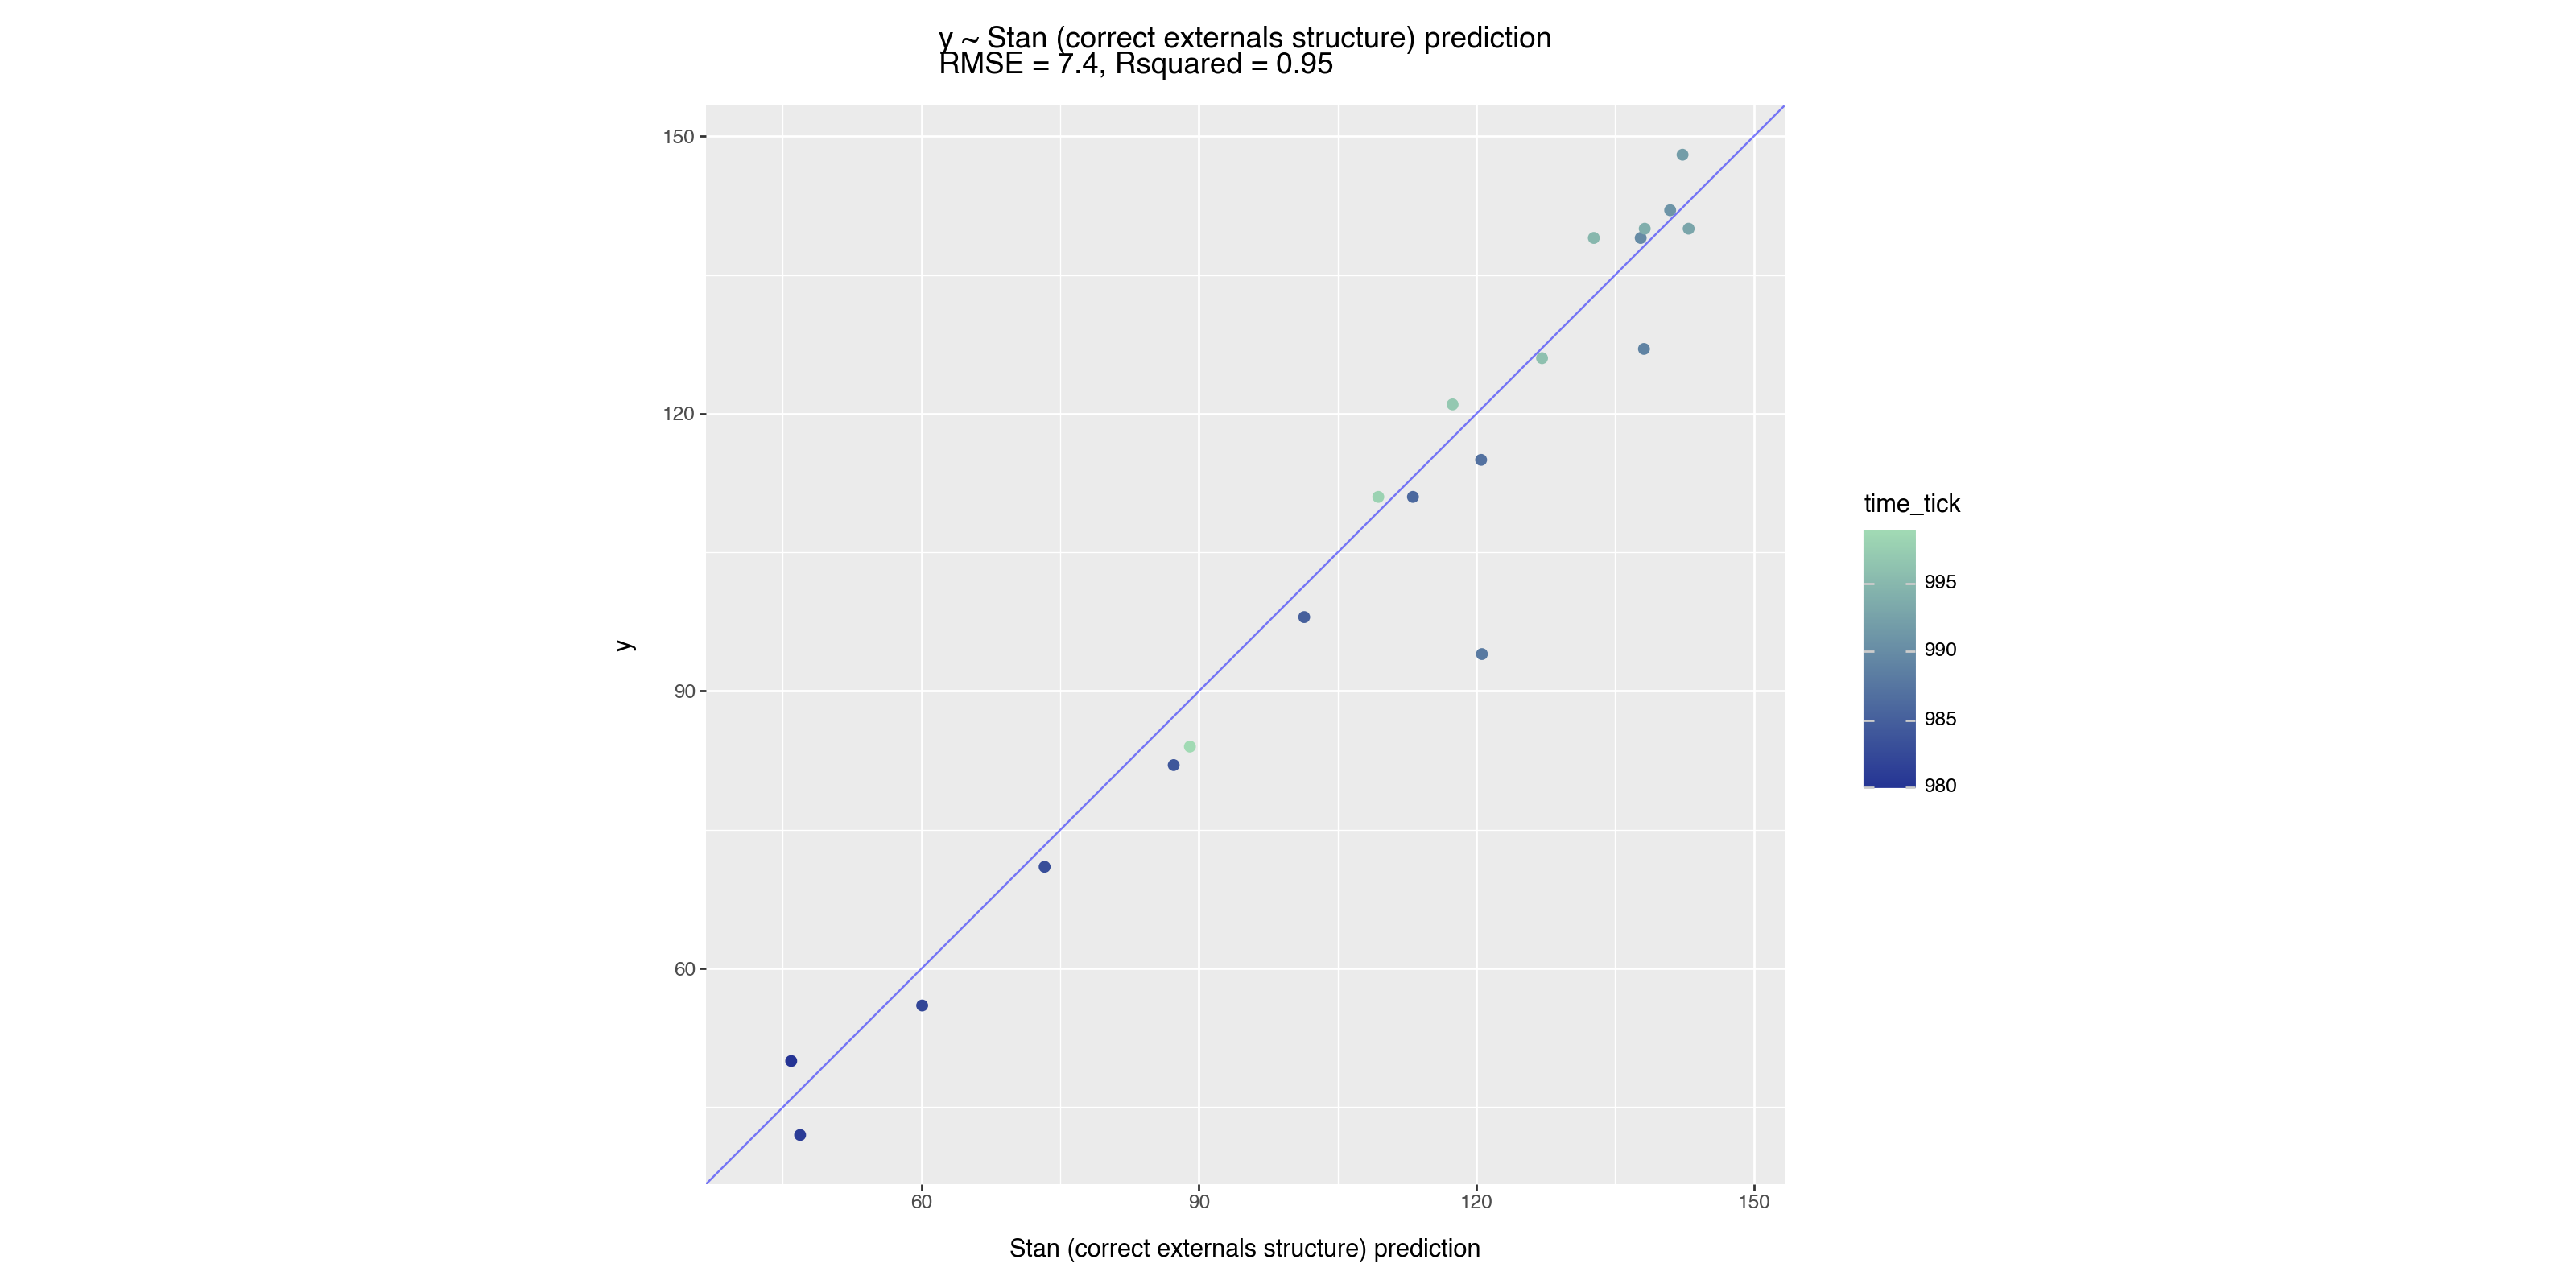

In [18]:
# plot quality of fit as a scatter plot
d_test["Stan (correct externals structure) prediction"] = extract_sframe_result(
    s_frame_i
)
plot_model_quality(
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
)

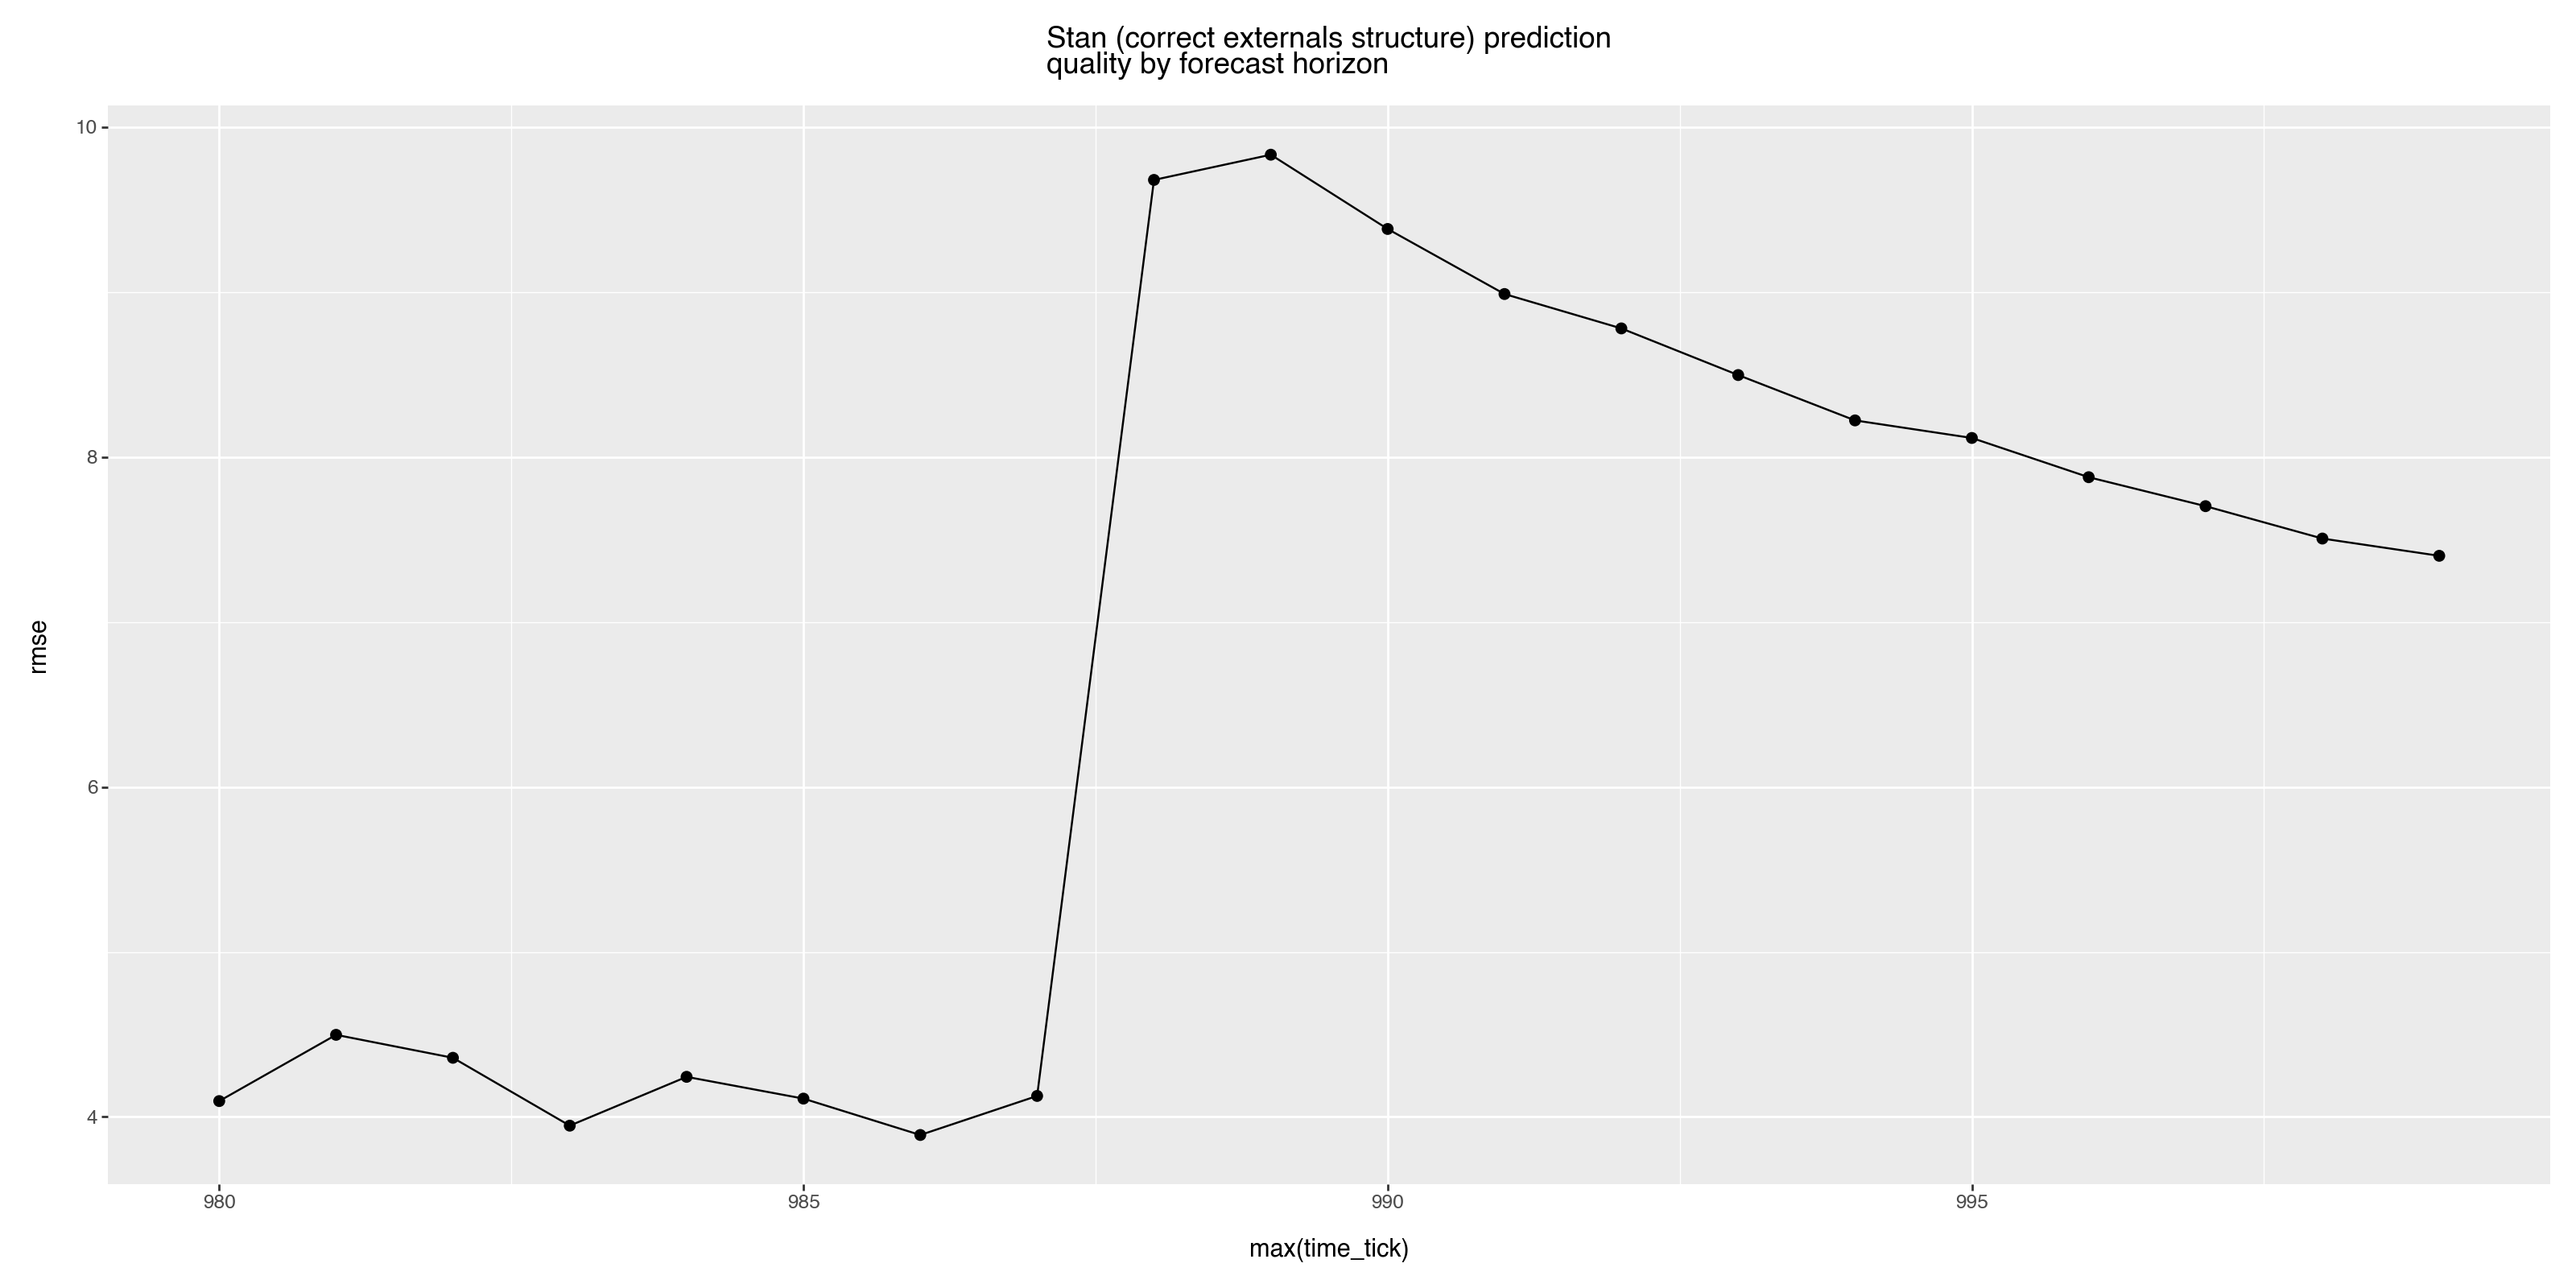

In [19]:
# plot quality as a function of how far out we are predicting
plot_model_quality_by_prefix(
    s_frame=s_frame_i,
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
)

The model identifies 4 very valuable things:

  * Estimates of not directly observed abstract demand.
  * Estimates of the model parameters.
  * Projections or applications of the model for future `time_tick`s 950 through 999.
  * Good inferences of the most recent unobserved states `y_auto[948]` and `y_auto[949]` in the training period.

The third item provides a much more useful estimate of then hidden state (based on evaluation of trajectories through the entire training period) than the simple single point estimate `y_auto[i] ~ y[i] * b_x_impl[0] - x_0[i]`. One can evolve estimates forward from these inferences, and that is not always the case for the simple expected value estimates.

Getting the exact right distributions is not always critical for this sort of application. Being able to sort the plausibility of fits is often sufficient. However, respecting some of the domain oriented gross behavior such as non-negativity (as we have here), Tobit style zero censorship (included), and possibly zero-inflated distributions (not yet modeled here) is key.

The issue with the simple (or naive) estimates being: they are single value point estimates, not necessarily compatible with *any* of the estimate sampling trajectories. Plugging in the naive estimates often does not allow one to evolve the prediction trajectories forward in a sensible manner. The detailed estimates from the Stan sampler do allow such forward evolution of estimates (either inside the Stan sampler as shown, or as a simple external procedure).


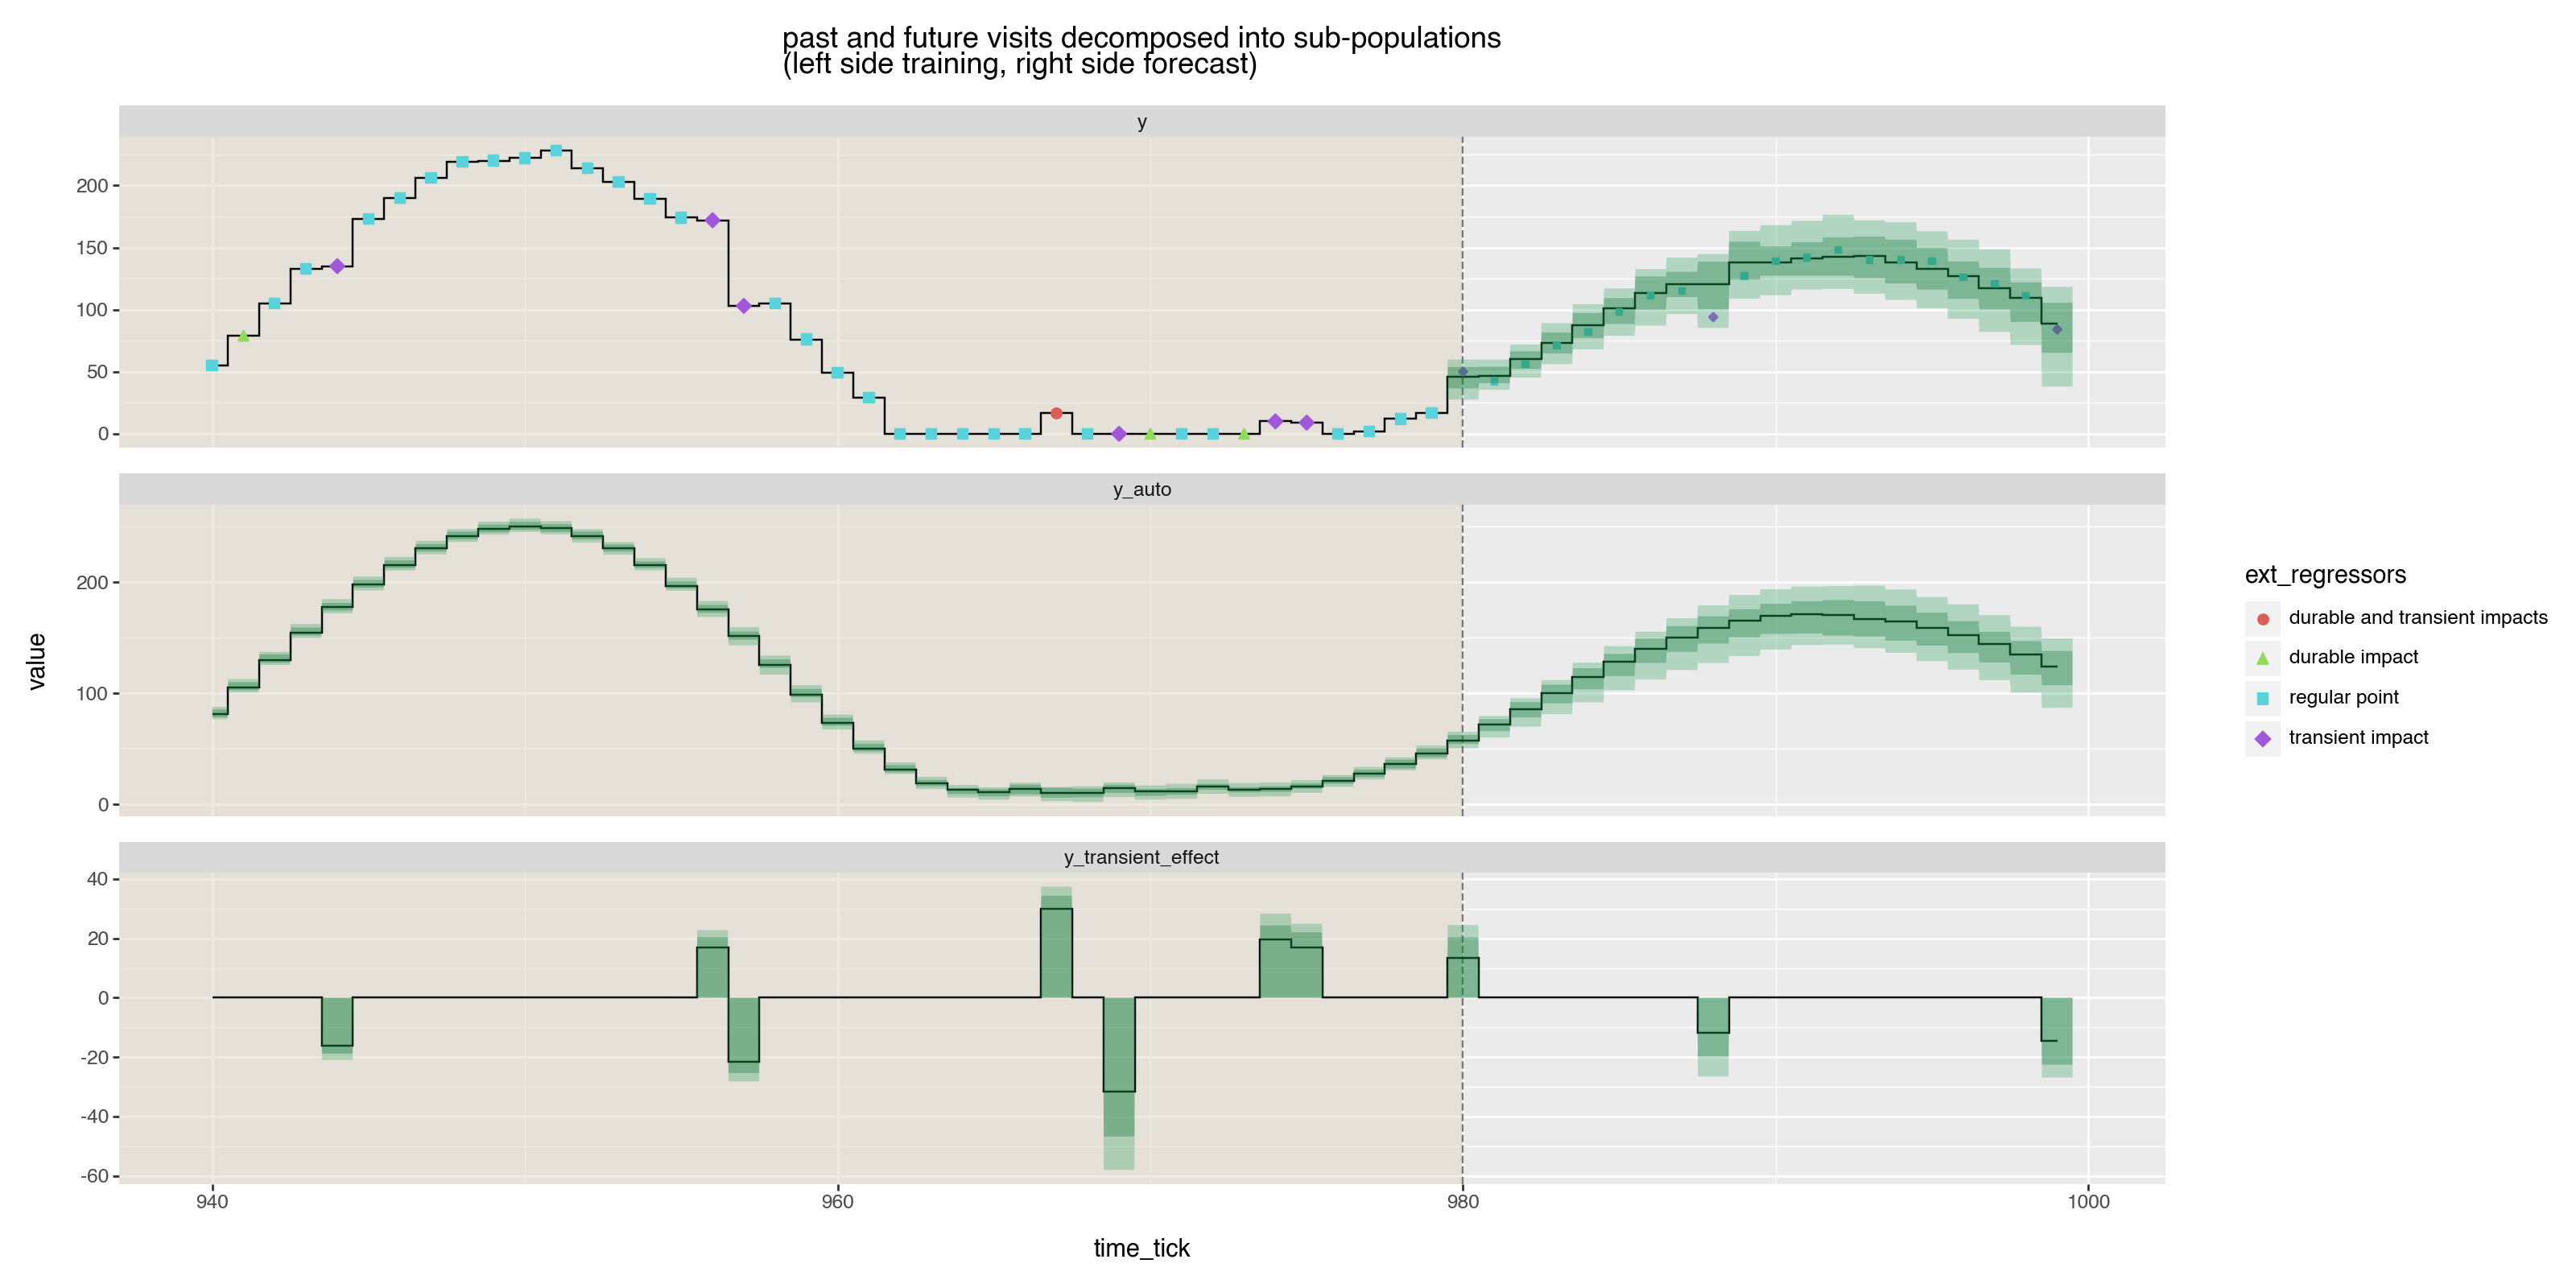

In [20]:
plot_decomposition(
    forecast_soln_i=forecast_soln_i,
    d_train=d_train,
    d_test=d_test,
)

Even external regressors that we don't know future values of can be useful. We can use them to de-bias model parameter estimation, and then without the future values the model is a golden path "if nothing happens" scenario. Projecting the projection forward with a few guessed external values can give sensitivity analysis.

The downsides of Stan include

  * It is slow and expensive to run.
  * It is non-deterministic, different runs may achieve different quality of results (requiring still more runs).
  * We saw failing runs in preparing this example (indicating need for longer run times to convergence).

## Conclusion


And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause transient effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.
